<a id='top'></a>
# PCA analysis on NIRSpec datacubes 
---
**Author**: Lina Issa (lina.issa@irap.omp.eu) 

**Latest Update**: 21 october 2022



#### <span style='color:rosybrown'>The aim of this notebook is to implement a *PCA* analysis on some small regions </span> 

To do that we average the NirSpec datacubes over the NirCam filters. 

#### <span style='color:darksalmon'> Importing stuff </span> 

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt 
import os, sys
import matplotlib
import plotly.offline as py
import plotly.express as px
import regions

from sklearn.utils.extmath import svd_flip
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy import linalg, ndimage
from numpy import matlib

from astropy.io         import fits 
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import sigma_clip
from astropy       import units as u

from matplotlib.cm import get_cmap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


from regions.core import PixCoord
from regions.shapes.circle import CirclePixelRegion
from regions               import RectanglePixelRegion

from PIL import Image
from PCA_Utilities import *

### <span style='color:darksalmon'> Loading the data cubes </span> 

In [2]:
directory    = './datacubes_corrected/'

In [3]:

cube_nirspec170_file = get_pkg_data_filename('./datacubes/nirspec_cube_pos_170lp.fits')
cube_nirspec170_data = fits.getdata(cube_nirspec170_file, ext=1) 

reduced_cube_nirspec170_data = cube_nirspec170_data[:1700,:,:]

Text(0.5, 1.0, 'Image at a given wavelength')

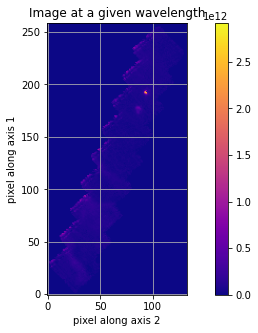

In [4]:
plt.figure(figsize=(10,5))
plt.imshow(cube_nirspec170_data[3294], cmap='plasma', origin='lower')
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.colorbar()
plt.grid()
plt.title('Image at a given wavelength')

F182M = [1.7, 2.0] 
F210M = [2.0, 2.2]
F187N =
F212N =
F164N =
F250M =

In [5]:
NirCam_Wave = np.linspace(1.6, 2.3, 3)
wavelength  = np.linspace(1.69997, 2.37317, 3663)

In [6]:
np.where(wavelength<2.23)[0][-1]

2883

cut survient à 2.012 micro

In [7]:
wavelength[2937]

2.2398903713817586

### <span style='color:darksalmon'> Selecting a thumbnail (vignette) around the proplyd </span> 

In [8]:
square_reduced_cube = resize(reduced_cube_nirspec170_data) # need to have a square data, otherwise regions package will complain !! 
center = PixCoord(86,177)
reg    = RectanglePixelRegion(center, width=20, height=20)#,angle=5 * u.deg)
mask   = reg.to_mask()
#mask.to_image(shape)
imagette = mask.cutout(square_reduced_cube[0])
#plt.imshow(mask.to_image(shape), cmap=plt.cm.viridis,
#           interpolation='nearest', origin='lower', vmin=)
imagette = np.ravel(imagette)


(150.0, 200.0)

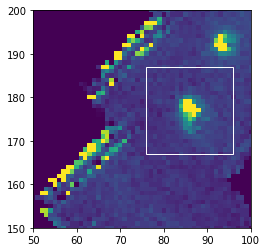

In [9]:
ax = plt.subplot(1, 1, 1)
ax.imshow(square_reduced_cube[650], cmap=plt.cm.viridis,
          interpolation='nearest', origin='lower', vmin=0, vmax=5e11)
ax.add_artist(reg.as_artist(facecolor='none', edgecolor='white'))
ax.set_xlim(50, 100)
ax.set_ylim(150, 200)

In [10]:
subcubeProplyd_nirspec_file = get_pkg_data_filename(directory + 'NIRSpec_subcube.fits')
subcubeProplyd_nirspec_data = fits.getdata(subcubeProplyd_nirspec_file, ext=1) 
cubeProplyd_1700            = subcubeProplyd_nirspec_data[:1700,:,:]


In [11]:
subcube_nirspec_mean_F182M = np.mean(subcubeProplyd_nirspec_data[0:1700], axis=0)
subcube_nirspec_mean_F210M = np.mean(subcubeProplyd_nirspec_data[2000:2883], axis=0)
subcube_nirspec_mean_F187N = np.mean(subcubeProplyd_nirspec_data[817:1089], axis=0)
subcube_nirspec_mean_F212N = np.mean(subcubeProplyd_nirspec_data[2177:2449], axis=0)

In [12]:
subcubeProplyd_nirspec_data.shape

(3663, 25, 25)

In [13]:
pix1, pix2 = cubeProplyd_1700.shape[1],  cubeProplyd_1700.shape[2]



Text(0.5, 1.0, 'Image at a given wavelength')

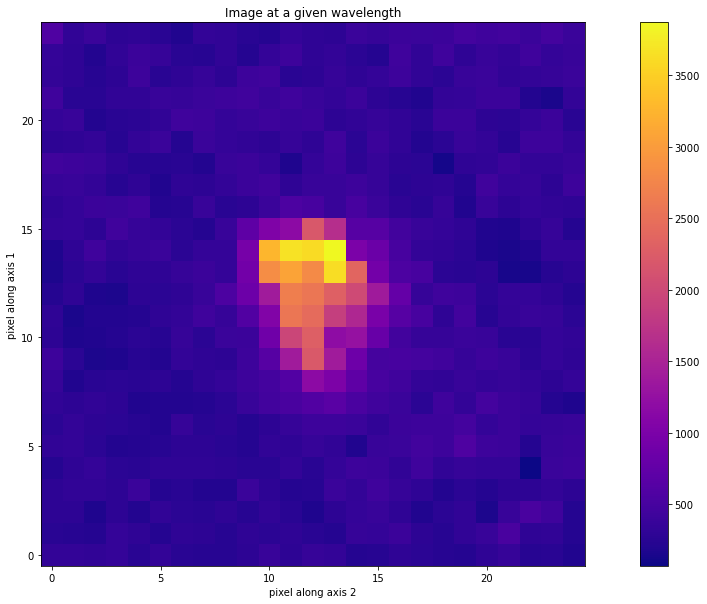

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(cubeProplyd_1700[652], cmap='plasma', origin='lower')
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.colorbar()
plt.title('Image at a given wavelength')

In [15]:
mask    = np.full((np.shape(cubeProplyd_1700)[1], np.shape(cubeProplyd_1700)[2]), False)
cubes2D = apply_mask(cubeProplyd_1700, mask)
cubes3D = repliage(1700, pix1, pix2, cubes2D, mask)
X = np.reshape(cubeProplyd_1700.copy(), (1700, pix1 * pix2)).T 
X_cube =  np.reshape(X.T, (1700, pix2, pix1)) 

In [16]:
X_cube.shape

(25, 25)

In [17]:
X = np.reshape(cubeProplyd_1700.copy(), (1700, pix1 * pix2)).T 

In [18]:
np.where(np.array(cubeProplyd_1700==X_cube) == False )

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [19]:
cubes2D_mean = np.mean(cubes2D, axis=0)
cubes2D -= cubes2D_mean
bands    = 1700

In [20]:
if cubes2D.shape[1] == bands: 
    %time covariance_matrix=np.cov(cubes2D.T)
else:
    %time covariance_matrix=np.cov(cubes2D)
    

CPU times: user 130 ms, sys: 17.7 ms, total: 148 ms
Wall time: 32.9 ms


In [21]:
%time eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

CPU times: user 10.1 s, sys: 160 ms, total: 10.3 s
Wall time: 1.33 s


In [22]:
ind=np.arange(0,len(eigen_values),1)
ind=[x for _,x in sorted(zip(eigen_values,ind))] #indexation par ordre croissant des vp
ind=ind[::-1]
sorted_eigen_values =eigen_values[ind] # sorted list in a decreasing order 
sorted_eigen_vectors=eigen_vectors[:,ind]
sorted_eigen_values[1699]

(-4.662927688885116e-07+0j)

/Users/lina/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



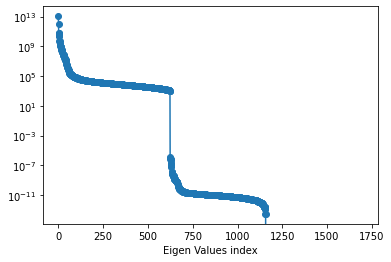

<Figure size 432x288 with 0 Axes>

In [202]:
x=np.arange(0,len(sorted_eigen_values),1)
plt.yscale('log')
plt.plot(x,sorted_eigen_values,marker = 'o' )

plt.xlabel("Eigen Values index")
plt.ylabel("")
plt.show()
plt.savefig("plots/EigenValuesDecrease_regionProplyd.pdf")

In [24]:
signatures_5 = sorted_eigen_vectors[:,:5] # on ne retient que les 10 premiers spectres 
wavelength    =  np.linspace(1.69997, 2.273, bands )
signatures_5
#plt.plot([wavelength]*10, [signatures_10[:,i] for i in range(10)])

#plt.plot(wavelength, signatures_10[:,8])

array([[ 1.54882262e-06+0.j, -3.20536866e-06+0.j,  2.21031838e-05+0.j,
         4.20556931e-05+0.j,  1.88057291e-05+0.j],
       [ 1.49884167e-06+0.j, -2.56522582e-06+0.j,  1.95728197e-05+0.j,
         2.28261305e-05+0.j,  1.35962156e-06+0.j],
       [ 1.15300721e-06+0.j,  1.22832468e-06+0.j,  1.05774229e-05+0.j,
         1.38963302e-05+0.j, -2.06676813e-05+0.j],
       ...,
       [-7.68650111e-07+0.j,  2.69275861e-06+0.j, -6.73864059e-06+0.j,
         1.49671479e-05+0.j,  1.96825404e-05+0.j],
       [ 5.83515028e-07+0.j,  4.35194295e-06+0.j, -6.86106183e-06+0.j,
         1.51501066e-05+0.j,  2.13521571e-05+0.j],
       [ 8.47930353e-07+0.j,  1.74050791e-06+0.j, -4.89947292e-06+0.j,
         6.13125026e-06+0.j,  8.14985131e-06+0.j]])

In [25]:
mask0 = compute_mask(cubeProplyd_1700)
True in mask0

False

no need for a mask masking the all-zeros pixels 

In [58]:
nb_comp = 100
#asterMask = masterMask | mask_allZeros
V, Z, X_mean, S = pca_nirspec(cubeProplyd_1700,nb_comp, mask,masked=None)
          
                              
                              

In [59]:
#Z_retroTEST, Z_cubeTES = retroprojection(V,Z,X_mean, mask, 1700)
pix1, pix2 = cubeProplyd_1700.shape[1],  cubeProplyd_1700.shape[2]


Z_2d = np.reshape(Z.copy(), (nb_comp, pix1 * pix2))
number_pixels =  Z_2d.shape[1]
Z_retro = np.dot(V, Z_2d) + np.matlib.repmat(X_mean, number_pixels, 1).T  # rétroprojection de Z
Z_cube  = np.reshape(Z_retro, (1700, pix1, pix2))
#negative = np.where(Z_cube<0)
#Z_cube[negative] = np.nan


Text(0.5, 1.0, 'Image at a given wavelength')

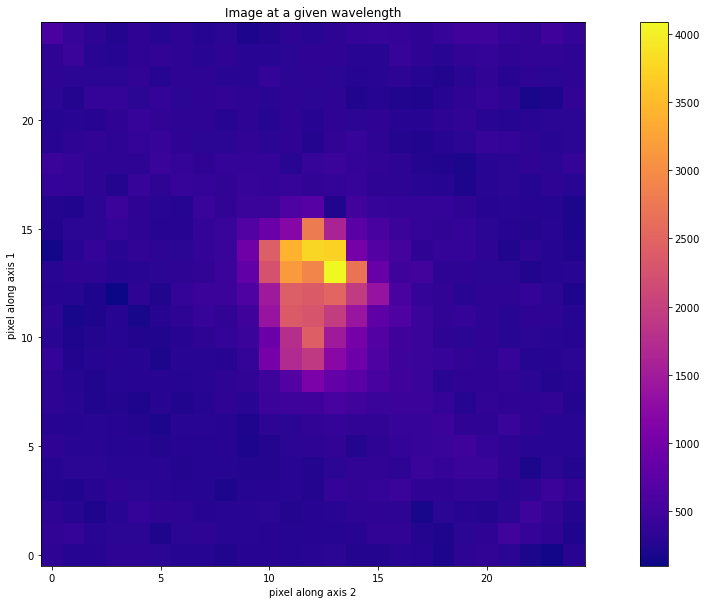

In [60]:
plt.figure(figsize=(20,10))
plt.imshow(Z_cube[652], cmap='plasma', origin='lower')
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.colorbar()
plt.title('Image at a given wavelength')

In [36]:
hdu = fits.PrimaryHDU(Z_cube) 
hdu.writeto(f'output_datacubes/nirspec_subcube_proplyd_170lp_retroprojected_{nb_comp}.fits', overwrite=True)

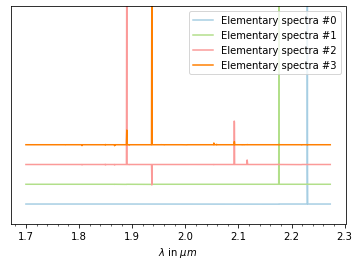

In [46]:
signatures_5 = V[:,:4] # on ne retient que les 10 premiers spectres 
bands = 1700
wavelength    =  np.linspace(1.69997, 2.273, bands )
fig, ax = plt.subplots()
cmap    = get_cmap('Paired')
for i in range(4):
    signatures_5[:,i] = signatures_5[:,i]/max(np.abs(signatures_5[:,i]))
    plt.plot(wavelength, signatures_5[:,i] + 0.1*i, c=cmap(i/5), label=f'Elementary spectra #{i}', alpha=1)

#plt.plot([wavelength]*10, [signatures_10[:,i] for i in range(10)])
ax.set_xlabel(r'$\lambda$ in $\mu m$')
ax.set_yticks([])
#plt.xlim(1.6,2.4)
ax.set_ylim(-0.1, 1)
#plt.savefig('5_spectres_pca.png')
plt.legend(loc='upper right')#, bbox_to_anchor=(0.5,1))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.02))

In [70]:
Yns_mask = apply_mask(cubeProplyd_1700, mask).T


In [71]:
pix1, pix2 = cubeProplyd_1700.shape[1],  cubeProplyd_1700.shape[2]


error   = check_pca(V,Z,X_mean, cubeProplyd_1700, mask, method='spectral')
x,y     = np.arange(pix1), np.arange(pix2) 
MX, MY  = np.meshgrid(y, x)
masked_image  = np.full((pix1, pix2), np.nan)
for x, y, z in zip(MX[~mask], MY[~mask], range(error.shape[0])):
    masked_image[ y, x] = error[z]  


1700 25 25 (1700, 625) (25, 25)


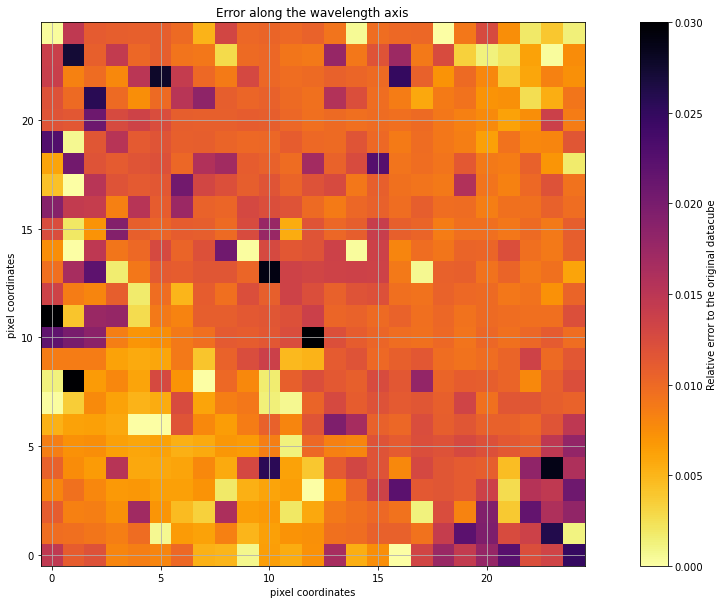

In [201]:
plt.figure(figsize=(20,10))
plt.imshow(masked_image, cmap='inferno_r', origin='lower', vmin=0, vmax=0.03)
plt.xlabel("pixel coordinates")
plt.ylabel("pixel coordinates")
plt.grid()
plt.colorbar(label='Relative error to the original datacube')
plt.title('Error along the wavelength axis')
plt.savefig("plots/mapOfErrors_regionProplyd.pdf")

In [113]:
error_spectra   = check_pca(V,Z,X_mean, Yns, mask, method='spatial')



1700 25 25 (1700, 625) (25, 25)


Text(0, 0.5, 'residu')

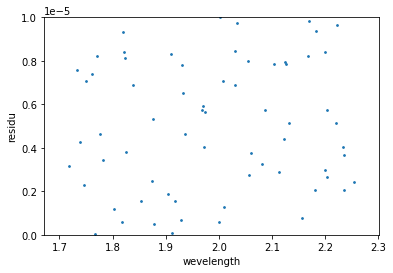

In [116]:
plt.scatter(wavelength, error_spectra, marker='o', s=3)
plt.ylim(0,1e-5)
plt.xlabel('wevelength')
plt.ylabel('residu')

Text(0.5, 1.0, 'Image at 1.958 $\\mu m$')

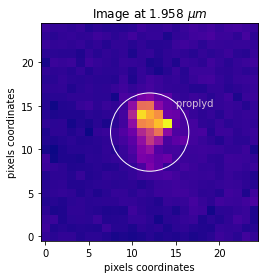

In [52]:
center = PixCoord(12,12)
reg    = CirclePixelRegion(center, 4.5)
mask   = reg.to_mask()
#mask.to_image(shape)
proplyd = mask.cutout(cubeProplyd_1700[0])
#plt.imshow(mask.to_image(shape), cmap=plt.cm.viridis,
#           interpolation='nearest', origin='lower', vmin=)
ax = plt.subplot(1, 1, 1)
ax.imshow(cubeProplyd_1700[650], cmap=plt.cm.plasma,
          interpolation='nearest', origin='lower')
ax.add_artist(reg.as_artist(facecolor='none', edgecolor='white'))
ax.text(15, 15, "proplyd ", color='thistle')#, bbox=dict(facecolor='plum', alpha=0.5))

ax.set_xlabel('pixels coordinates')
ax.set_ylabel('pixels coordinates')
ax.set_title(f'Image at 1.958 $\mu m$')

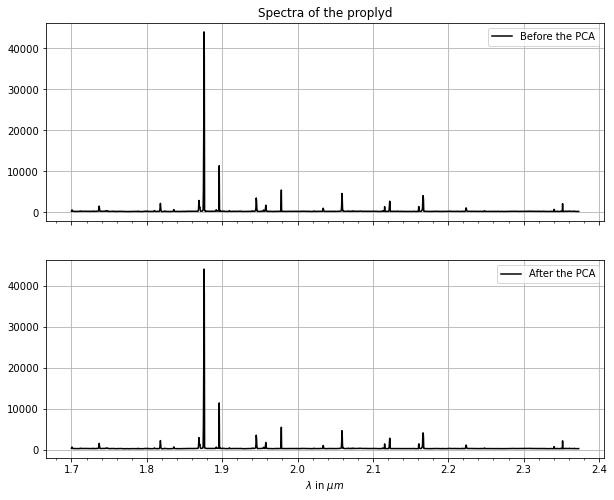

In [200]:
spectra_proplyd_beforePCA = plot_spectra(cubeProplyd_1700,reg)
spectra_proplyd_afterPCA  = plot_spectra(Z_cube,reg)
wavelength   = np.linspace(1.69997, 2.37317, bands)


fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True, sharey=True)
ax[0].plot(wavelength, spectra_proplyd_beforePCA, color='black', label='Before the PCA')
ax[1].plot(wavelength, spectra_proplyd_afterPCA, color='black', label='After the PCA')
ax[0].set_title( "Spectra of the proplyd", loc='center')
ax[1].set_xlabel(r'$\lambda$ in $\mu m$')
ax[0].grid(True)
ax[1].grid(True)

ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.02))
ax[0].legend()
ax[1].legend()
plt.savefig("plots/ProplydSpectraRegion.pdf")

In [57]:
F182M = np.genfromtxt("NirCam_filters/F182M.txt", delimiter = " ", skip_header=1)
F162M = np.genfromtxt("NirCam_filters/F162.txt", delimiter = " ", skip_header=1)
F187N = np.genfromtxt("NirCam_filters/F187N.txt", delimiter = " ", skip_header=1)
F200W = np.genfromtxt("NirCam_filters/F200W.txt", delimiter = " ", skip_header=1)
F210M = np.genfromtxt("NirCam_filters/F210M.txt", delimiter = " ", skip_header=1)

In [120]:
wave = F182M[:,0]
transmission = F182M[:,1]

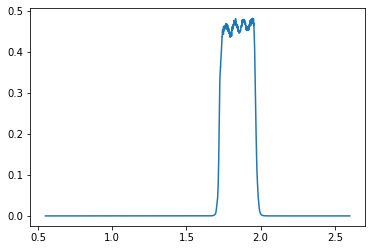

In [121]:
plt.plot(wave, transmission)

from https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters


In [122]:
pos1 = np.where(wave>1.5)[0][0]
pos2 = np.where(wave<=2.5)[0][-1]
print(pos1, pos2)

950 1949


In [123]:
pos1 = np.where(wave>1.5)[0][0]
pos2 = np.where(wave<=2.5)[0][-1]

In [124]:
print(pos1, pos2)

950 1949


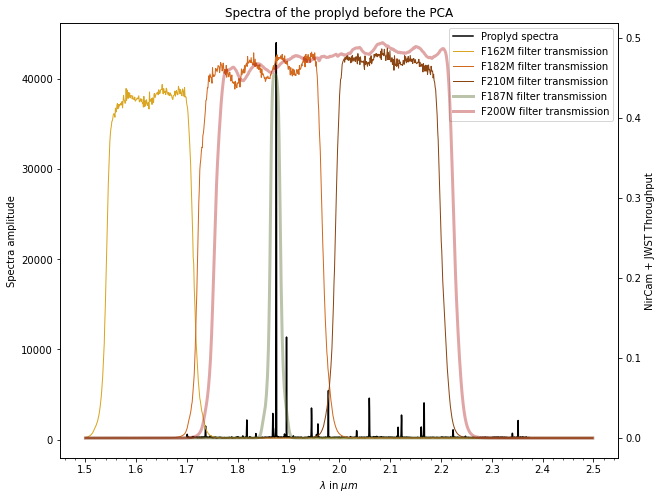

In [198]:
from matplotlib.lines import Line2D
line = [Line2D([0],[0], ls='-', color="black"),
        Line2D([0],[0], ls='-', color="goldenrod", linewidth=1),
        Line2D([0],[0], ls='-', color="chocolate", linewidth=1),
        Line2D([0],[0], ls='-', color="saddlebrown", linewidth=1),
        Line2D([0],[0], ls='-', color="darkolivegreen", linewidth=3,alpha=0.4),
        Line2D([0],[0], ls='-', color="firebrick", linewidth=3,alpha=0.4)]
label=['Proplyd spectra','F162M filter transmission', 'F182M filter transmission', 'F210M filter transmission','F187N filter transmission','F200W filter transmission']
wave_transmission = F182M[pos1:pos2,0]
fig, ax = plt.subplots(1,1, figsize=(10,8), sharex=True, sharey=False)
ax.plot(wavelength, spectra_proplyd_beforePCA, color='black', label='Before the PCA')
ax.set_title( "Spectra of the proplyd before the PCA" , loc='center')
ax.set_xlabel(r'$\lambda$ in $\mu m$')
ax.legend(handles=line, labels=label)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.02))

ax2 = ax.twinx()
ax2.plot(wave_transmission,F162M[pos1:pos2,1], color='goldenrod', linewidth=1, label='F162M filter transmission')
ax2.plot(wave_transmission,F182M[pos1:pos2,1], color='chocolate',linewidth=1 ,label='F182M filter transmission')
ax2.plot(wave_transmission,F210M[pos1:pos2,1], color='saddlebrown', linewidth=1 ,label='F210M filter transmission')
ax2.plot(wave_transmission,F187N[pos1:pos2,1], color='darkolivegreen',linewidth=3,  alpha=0.4,label='F187N filter transmission')
ax2.plot(wave_transmission,F200W[pos1:pos2,1], color='firebrick',linewidth=3, alpha=0.4, label='F200W filter transmission')

ax.set_ylabel(r'Spectra amplitude')
ax2.set_ylabel(r'NirCam + JWST Throughput')

plt.savefig("plots/SpectraProplyd+transmissionFilters.pdf")

Module-averaged total system transmission curves for some NirCam filters